In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from src.model.instance_hardness import *
from src.model.support_subset import *
from src.utils import *
from src.visualization.plots import *
from src.model.wncn import *

np.random.seed(1234)

n = 1000

mu1, mu2, sigma = 0, -2, 1

X1 = np.random.normal(mu1, sigma, size=[n, 2])
X2 = np.random.normal(mu2, sigma, size=[n, 2])
X3 = np.random.normal([-2, 2], 0.5, size=[n, 2])
X = np.vstack((X1, X2, X3))

y = np.hstack((np.zeros(int(len(X1))),np.ones(int(len(X2) + len(X3))))).astype(int)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Conjunto de datos de train

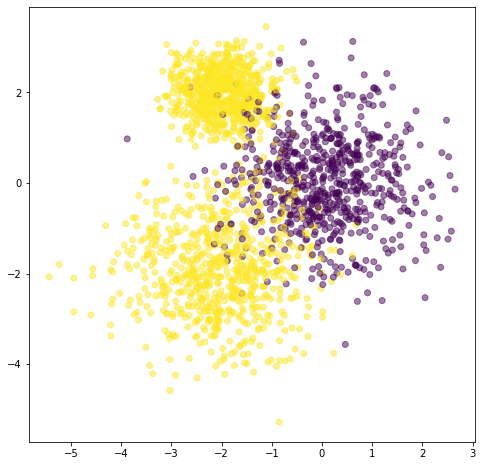

In [4]:
figure, axes = plt.subplots(figsize=[8, 8])

plt.scatter(X_train[:,0],X_train[:,1], c=y_train, alpha=0.5)

plt.show()

### Cálculo de complejidad

#### KDN

In [5]:
complexity, _ = kdn_score(X_train, y_train, 5)

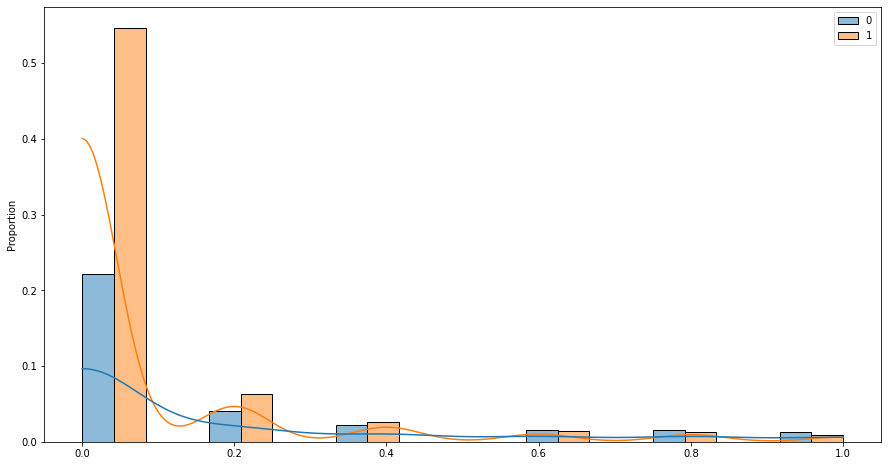

In [6]:
plt.figure(figsize=(15,8))
sns.histplot(x=complexity, hue=y_train.astype(int), kde=True, multiple='dodge', stat='proportion');

In [7]:
global_complexity = np.mean(complexity)
class0_complexity = np.mean(complexity[y_train < 1])
class1_complexity = np.mean(complexity[y_train > 0])

In [8]:
global_complexity

0.10238805970149255

In [9]:
class1_complexity

0.07505551443375277

In [10]:
class0_complexity

0.15842185128983308

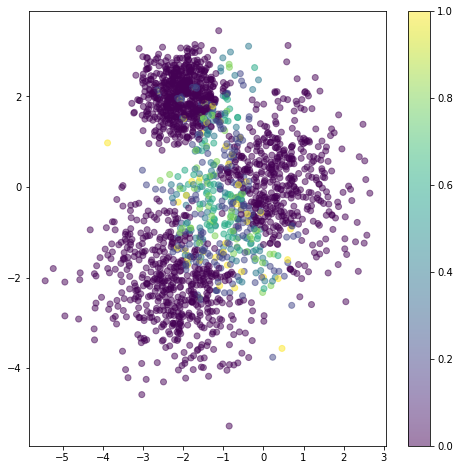

In [11]:
figure, axes = plt.subplots(figsize=[8, 8])

plt.scatter(X_train[:,0],X_train[:,1], c=complexity, alpha=0.5)

plt.colorbar()

plt.show()

#### Dynamic KDN

In [28]:
dynamic_kdn = DynamicInstanceNeighbourhoodComplexity(k=3)
dynamic_kdn.fit(X_train, y_train)
complexity_d = dynamic_kdn.hardness

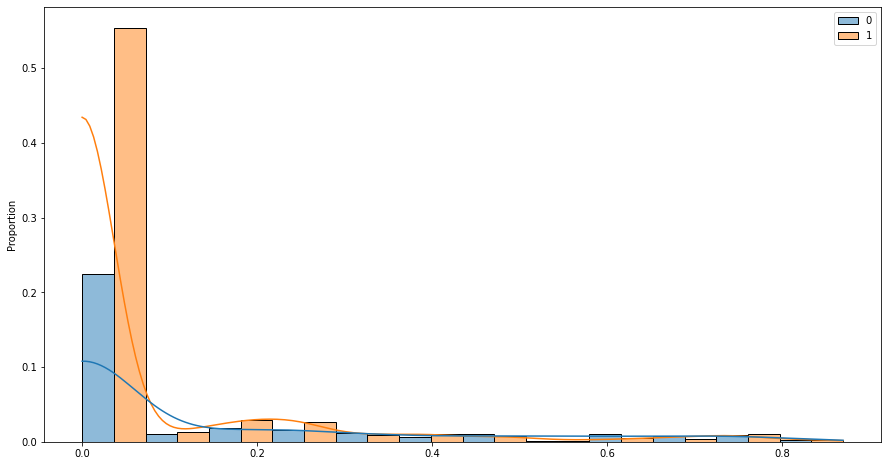

In [29]:
plt.figure(figsize=(15,8))
sns.histplot(x=complexity_d, hue=y_train.astype(int), kde=True, multiple='dodge', stat='proportion');

In [16]:
global_complexity_d = np.mean(complexity_d)
class0_complexity_d = np.mean(complexity_d[y_train < 1])
class1_complexity_d = np.mean(complexity_d[y_train > 0])

In [17]:
global_complexity_d

0.08801990049751245

In [18]:
class1_complexity_d

0.06449296817172465

In [19]:
class0_complexity_d

0.13625189681335356

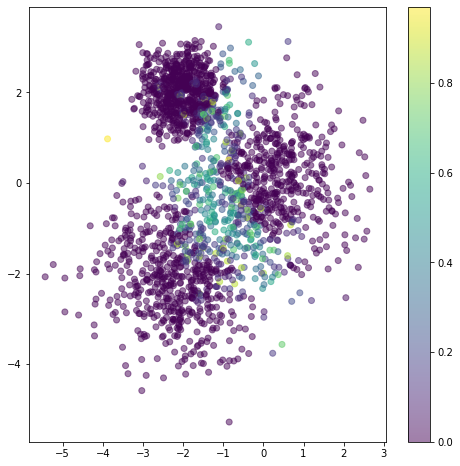

In [20]:
figure, axes = plt.subplots(figsize=[8, 8])

plt.scatter(X_train[:,0],X_train[:,1], c=complexity_d, alpha=0.5)

plt.colorbar()

plt.show()

### Estimación del support subset 

Estimo el support subset con un muestreo sobre la complejidad acorde a una distribución normal (0.5, 0.15) para muestrear con más frecuencia los puntos más complejos (a priori puntos en la frontera) 

#### Sin muestrear por clase

In [30]:
percs = list(range(5, 100, 5))
ss_idx = weighted_sample(complexity, prop_sample=[i*0.01 for i in percs], random_state=1234, distribution=np.random.normal, kwargs={'loc':0.5, 'scale':0.15, 'size':100000})

In [31]:
ss_class1 = []
ss_class0 = []
complexities = []
complexities_class1 = []
complexities_class0 = []

for ids in ss_idx:
    compl, _ = kdn_score(X_train[ids], y_train[ids], 5)
    complexities.extend([np.mean(compl)])
    complexities_class0.append(np.mean(compl[y_train[ids] < 1]))
    complexities_class1.append(np.mean(compl[y_train[ids] > 0]))

complexities.extend([global_complexity])
complexities_class0.extend([class0_complexity])
complexities_class1.extend([class1_complexity])

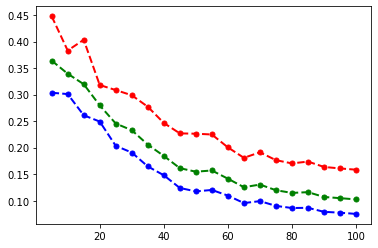

In [32]:
plt.plot(percs+[100], complexities_class1, 'bo--', linewidth=2, markersize=5);
plt.plot(percs+[100], complexities_class0, 'ro--', linewidth=2, markersize=5);
plt.plot(percs+[100], complexities, 'go--', linewidth=2, markersize=5);

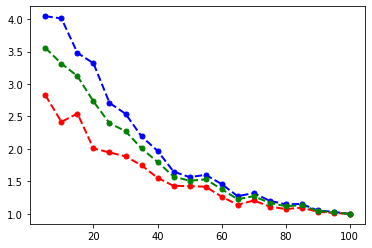

In [33]:
plt.plot(percs+[100], complexities_class1/class1_complexity, 'bo--', linewidth=2, markersize=5);
plt.plot(percs+[100], complexities_class0/class0_complexity, 'ro--', linewidth=2, markersize=5);
plt.plot(percs+[100], complexities/global_complexity, 'go--', linewidth=2, markersize=5);

In [34]:
ss_idx = weighted_sample(complexity, prop_sample=0.1, random_state=1234, distribution=np.random.normal, kwargs={'loc':0.5, 'scale':0.1, 'size':100000})

In [35]:
X_smpl = X_train[ss_idx]
y_smpl = y_train[ss_idx]

In [36]:
np.unique(y_smpl, return_counts=True)[1]/len(y_smpl)

array([0.46766169, 0.53233831])

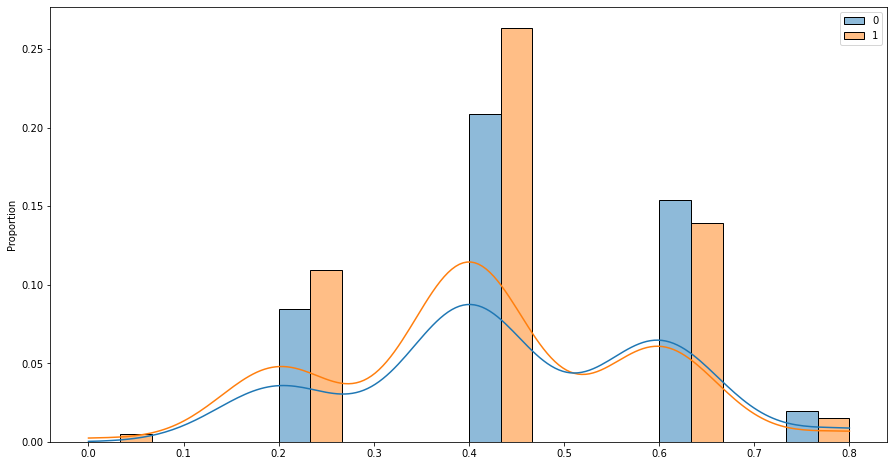

In [44]:
plt.figure(figsize=(15,8))
sns.histplot(x=complexity[ss_idx], hue=y_train[ss_idx].astype(int), kde=True, multiple='dodge', stat='proportion');

Se observa que la relación de puntos más complejos en la muestra aumenta respecto de la distribución inicial de complejidad.

Representamos ahora la muestra del subconjunto soporte.

In [ ]:
figure, axes = plt.subplots(figsize=[8, 8])

plt.scatter(X_smpl[:,0],X_smpl[:,1], c=y_smpl, alpha=0.5)

plt.show()

### Estimación de la frontera de decisión con RF

Frontera de decisión en train

In [38]:
rf = RandomForestClassifier(n_estimators=1000, max_features='auto', criterion='gini',random_state=1324)
rf.fit(X_train, y_train);

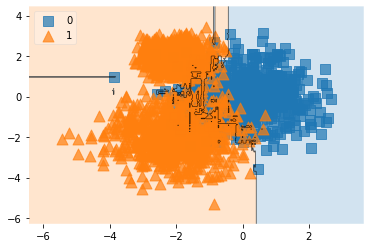

In [39]:
fig1 = plt.gcf()
custom_decision_region_plot(X_train, y_train, rf, title='')

Matriz de confusión en test

In [40]:
preds = rf.predict(X_test)
confusion_matrix(preds, y_test)

real,0,1,total
pred,,,
0,0.2919,0.0253,0.3172
1,0.0525,0.6303,0.6828
total,0.3444,0.6556,1.0000


Frontera de decisión con support subset

In [41]:
rf = RandomForestClassifier(n_estimators=1000, max_features='auto', criterion='gini',random_state=1324)
rf.fit(X_smpl, y_smpl);

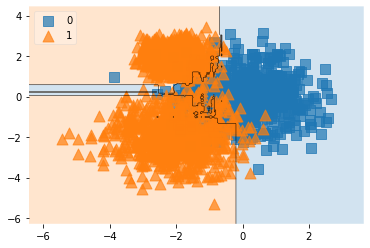

In [42]:
fig1 = plt.gcf()
custom_decision_region_plot(X_train, y_train, rf, title='')

Matriz de confusión en test, entrenado con support subset

In [33]:
preds = rf.predict(X_test)
confusion_matrix(preds, y_test)

real,0,1,total
pred,,,
0,0.2929,0.0253,0.3182
1,0.0515,0.6303,0.6818
total,0.3444,0.6556,1.0000


### Estimación de la frontera de decisión con SVM

Frontera de decisión en train

In [34]:
svm = SVC(C=1, gamma = 0.1)
svm.fit(X_train, y_train);

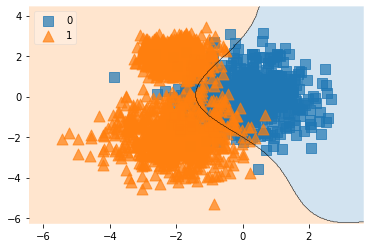

In [35]:
fig1 = plt.gcf()
custom_decision_region_plot(X_train, y_train, svm, title='')

Matriz de confusión en test

In [36]:
preds = svm.predict(X_test)
confusion_matrix(preds, y_test)

real,0,1,total
pred,,,
0,0.2970,0.0242,0.3212
1,0.0475,0.6313,0.6788
total,0.3444,0.6556,1.0000


Frontera de decisión con support subset

In [37]:
svm = SVC(C=1, gamma = 0.1)
svm.fit(X_smpl, y_smpl);

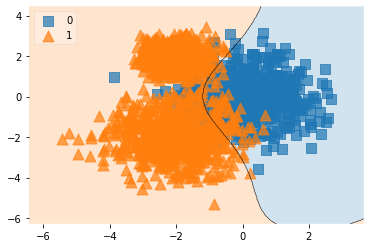

In [38]:
fig1 = plt.gcf()
custom_decision_region_plot(X_train, y_train, svm, title='')

Matriz de confusión en test, entrenado con support subset

In [39]:
preds = svm.predict(X_test)
confusion_matrix(preds, y_test)

real,0,1,total
pred,,,
0,0.2960,0.0273,0.3232
1,0.0485,0.6283,0.6768
total,0.3444,0.6556,1.0000


#### Muestreando por clase

In [40]:
complexities = []
percs = list(range(5, 100, 5))
ss_idx = weighted_sample(complexity, y=y_train, prop_sample=[i*0.01 for i in percs], random_state=1234, distribution=np.random.normal, kwargs={'loc':0.5, 'scale':0.15, 'size':100000})
for i in ss_idx:
    complexities.extend([np.mean(complexity[i])])
complexities.extend([global_complexity])

In [41]:
ss_class1 = []
ss_class0 = []
complexities = []
complexities_class1 = []
complexities_class0 = []

for ids in ss_idx:
    compl, _ = kdn_score(X_train[ids], y_train[ids], 5)
    complexities.extend([np.mean(compl)])
    complexities_class0.append(np.mean(compl[y_train[ids] < 1]))
    complexities_class1.append(np.mean(compl[y_train[ids] > 0]))

complexities.extend([global_complexity])
complexities_class0.extend([class0_complexity])
complexities_class1.extend([class1_complexity])

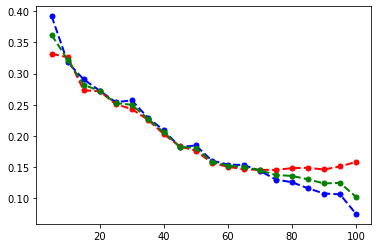

In [42]:
plt.plot(percs+[100], complexities_class1, 'bo--', linewidth=2, markersize=5);
plt.plot(percs+[100], complexities_class0, 'ro--', linewidth=2, markersize=5);
plt.plot(percs+[100], complexities, 'go--', linewidth=2, markersize=5);

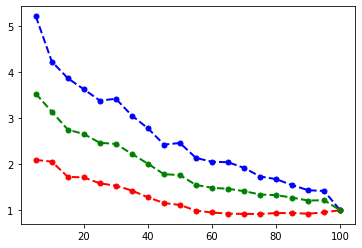

In [43]:
plt.plot(percs+[100], complexities_class1/class1_complexity, 'bo--', linewidth=2, markersize=5);
plt.plot(percs+[100], complexities_class0/class0_complexity, 'ro--', linewidth=2, markersize=5);
plt.plot(percs+[100], complexities/global_complexity, 'go--', linewidth=2, markersize=5);

In [44]:
ss_idx = weighted_sample(complexity, y=y_train, prop_sample=0.1, random_state=1234, distribution=np.random.normal, kwargs={'loc':0.5, 'scale':0.15, 'size':100000})

In [45]:
X_smpl = X_train[ss_idx]
y_smpl = y_train[ss_idx]

In [46]:
np.unique(y_smpl, return_counts=True)[1]/len(y_smpl)

array([0.5, 0.5])

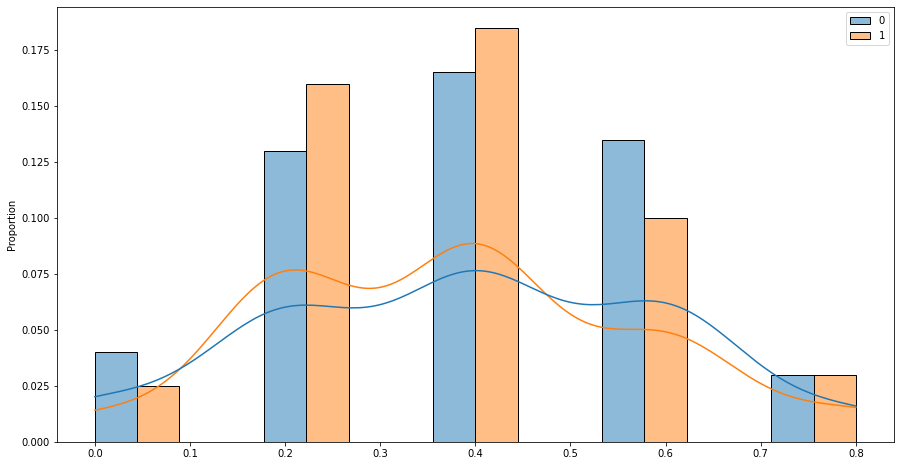

In [47]:
plt.figure(figsize=(15,8))
sns.histplot(x=complexity[ss_idx], hue=y_smpl.astype(int), kde=True, multiple='dodge', stat='proportion');

Se observa que la relación de puntos más complejos en la muestra aumenta respecto de la distribución inicial de complejidad.

Representamos ahora la muestra del subconjunto soporte.

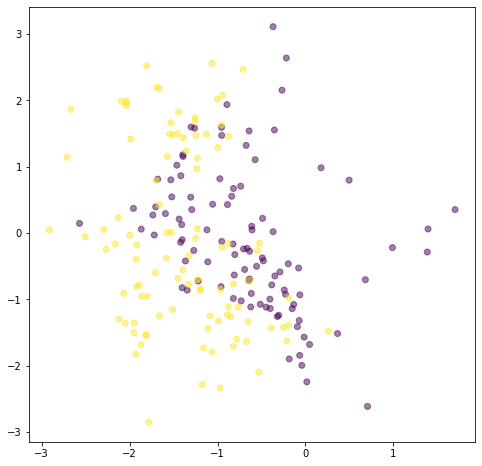

In [48]:
figure, axes = plt.subplots(figsize=[8, 8])

plt.scatter(X_smpl[:,0],X_smpl[:,1], c=y_smpl, alpha=0.5)

plt.show()

### Estimación de la frontera de decisión con RF

Frontera de decisión en train

In [49]:
rf = RandomForestClassifier(n_estimators=1000, max_features='auto', criterion='gini',random_state=1324)
rf.fit(X_train, y_train);

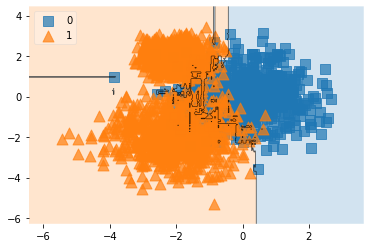

In [50]:
fig1 = plt.gcf()
custom_decision_region_plot(X_train, y_train, rf, title='')

Matriz de confusión en test

In [51]:
preds = rf.predict(X_test)
confusion_matrix(preds, y_test)

real,0,1,total
pred,,,
0,0.2919,0.0253,0.3172
1,0.0525,0.6303,0.6828
total,0.3444,0.6556,1.0000


Frontera de decisión con support subset

In [52]:
rf = RandomForestClassifier(n_estimators=1000, max_features='auto', criterion='gini',random_state=1324)
rf.fit(X_smpl, y_smpl);

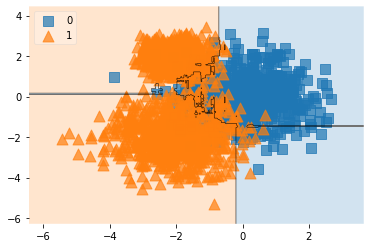

In [53]:
fig1 = plt.gcf()
custom_decision_region_plot(X_train, y_train, rf, title='')

Matriz de confusión en test, entrenado con support subset

In [54]:
preds = rf.predict(X_test)
confusion_matrix(preds, y_test)

real,0,1,total
pred,,,
0,0.3000,0.0273,0.3273
1,0.0444,0.6283,0.6727
total,0.3444,0.6556,1.0000


### Estimación de la frontera de decisión con SVM

Frontera de decisión en train

In [55]:
svm = SVC(C=1, gamma = 0.1)
svm.fit(X_train, y_train);

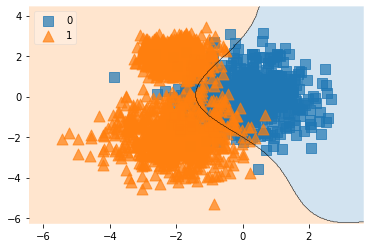

In [56]:
fig1 = plt.gcf()
custom_decision_region_plot(X_train, y_train, svm, title='')

Matriz de confusión en test

In [57]:
preds = svm.predict(X_test)
confusion_matrix(preds, y_test)

real,0,1,total
pred,,,
0,0.2970,0.0242,0.3212
1,0.0475,0.6313,0.6788
total,0.3444,0.6556,1.0000


Frontera de decisión con support subset

In [58]:
svm = SVC(C=1, gamma = 0.1)
svm.fit(X_smpl, y_smpl);

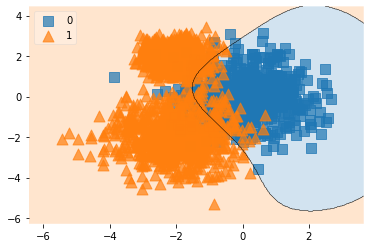

In [59]:
fig1 = plt.gcf()
custom_decision_region_plot(X_train, y_train, svm, title='')

Matriz de confusión en test, entrenado con support subset

In [60]:
preds = svm.predict(X_test)
confusion_matrix(preds, y_test)

real,0,1,total
pred,,,
0,0.3051,0.0313,0.3364
1,0.0394,0.6242,0.6636
total,0.3444,0.6556,1.0000
